In [1]:
import numpy as np
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.random 
import jax.lax as lax

#config.update("jax_debug_nans", True)

from jax import grad, jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')
import seaborn as sns


#from sklearn.metrics import pairwise_distances
import os

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

/Users/aduncan/opt/anaconda3/envs/iot/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/aduncan/opt/anaconda3/envs/iot/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
import numpyro
#numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Multinomial,
    Dirichlet,
    Normal,
    Uniform,
    Exponential,
    LogNormal,
    TruncatedNormal
 )
from numpyro.infer import MCMC, NUTS, Predictive, BarkerMH, SA


In [20]:
rng = jax.random.PRNGKey(0)
keys = jax.random.split(rng, 5)

N, M = 5,5

In [29]:
a = jnp.ones((N,))/N

b = jnp.arange(1,M+1)**2
b = b/jnp.sum(b)

a = jax.random.uniform(keys[0], (N,1))
b = jax.random.uniform(keys[1], (M,1))
a = a.ravel() / jnp.sum(a)
b = b.ravel() / jnp.sum(b)
print('mu ', a)
print('nu ', b)
eps = 1.0
index = 2

mu  [0.17111642 0.1938811  0.08688396 0.44707095 0.10104758]
nu  [0.4455814  0.34930909 0.15023578 0.00728408 0.04758965]


In [30]:
def generate_data(N, M, a, b, eps):
    
    K1 = np.zeros(shape=(M,N))
         
    for i in jnp.arange(0,N):
        c_truth = np.random.dirichlet(np.ones(M))
        K1[:,i] = c_truth
    
    C_truth = jnp.array(-eps * np.log(K1))
 
    geom = ott.geometry.geometry.Geometry(cost_matrix=C_truth, epsilon=eps)
    prob = linear_problem.LinearProblem(geom, a=a, b=b)
    solver = sinkhorn.Sinkhorn(inner_iterations=100, max_iterations=10000, jit=True)
    out = solver(prob)
    print(
    " Sinkhorn has converged: ",
    out.converged,
    "\n",
    "Error upon last iteration: ",
    out.errors[(out.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(out.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    out.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(out.matrix * out.geom.cost_matrix),
    )
    T = geom.transport_from_potentials(out.f, out.g)
    print('OT map:', T)
    return T, C_truth


In [31]:
def calcK(T, v, index):
    D = jnp.diag(jnp.divide(v,T[:,index]))
    K = jnp.dot(D,T)
    sumK = jnp.sum(K,axis=0, keepdims=True)
    return K/sumK

In [32]:
def solveOT(K, a, b, eps):
    C = jnp.array(-eps * jnp.log(K))
    geom = ott.geometry.geometry.Geometry(cost_matrix=C, epsilon = eps)
    prob = linear_problem.LinearProblem(geom, a=a, b=b)
    solver = sinkhorn.Sinkhorn(inner_iterations=100, max_iterations=10000, jit=True)
    out = solver(prob)
    T = geom.transport_from_potentials(out.f, out.g)
    return T

In [33]:
def model(N, M, eps, data):

    cvec = numpyro.sample("K", Dirichlet(jnp.ones(N)))
    K = calcK(data, cvec, index)
    T = solveOT(K, a, b, eps)
 

In [34]:
T_data, C_truth = generate_data(N, M, a, b, eps)
K_truth = np.exp(-C_truth)


 Sinkhorn has converged:  True 
 Error upon last iteration:  9.107298248878237e-17 
 Sinkhorn required  1  iterations to converge. 
 Entropy regularized OT cost:  1.6954355069592975 
 OT cost (without entropy):  1.406609029903958
OT map: [[1.87842479e-02 1.45485984e-01 4.15472499e-03 2.23775968e-03
  4.53698836e-04]
 [5.43922915e-02 7.19855701e-03 9.73203311e-02 3.96480594e-03
  3.10051144e-02]
 [1.68763298e-02 5.40227367e-02 9.61560700e-03 2.46216574e-05
  6.34466213e-03]
 [3.02030487e-01 1.01117873e-01 3.50863765e-02 6.31620343e-04
  8.20459488e-03]
 [5.34980458e-02 4.14839376e-02 4.05874349e-03 4.25274321e-04
  1.58157533e-03]]


In [35]:
mcmc = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=1000,
        num_samples=10000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)


mcmc.run(rng, N=N, M =M, eps=eps, data=T_data)
mcmc.print_summary()


sample: 100%|█| 11000/11000 [00:06<00:00, 1617.19it/s, 7 steps of size 6.06e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      K[0]      0.20      0.16      0.16      0.00      0.43  11244.22      1.00
      K[1]      0.20      0.16      0.16      0.00      0.44  11784.13      1.00
      K[2]      0.20      0.17      0.16      0.00      0.45  11154.34      1.00
      K[3]      0.20      0.16      0.16      0.00      0.43  10203.47      1.00
      K[4]      0.20      0.16      0.16      0.00      0.44  10499.26      1.00

Number of divergences: 0


In [36]:
sample = mcmc.get_samples()
Kmean = jnp.mean(sample['K'], axis=0)
K = calcK(T_data, Kmean, index)
T = solveOT(K, a, b, eps)
print('Exact transport plan: ', T_data)
print('Posterior transport plan: ', T)

Exact transport plan:  [[1.87842479e-02 1.45485984e-01 4.15472499e-03 2.23775968e-03
  4.53698836e-04]
 [5.43922915e-02 7.19855701e-03 9.73203311e-02 3.96480594e-03
  3.10051144e-02]
 [1.68763298e-02 5.40227367e-02 9.61560700e-03 2.46216574e-05
  6.34466213e-03]
 [3.02030487e-01 1.01117873e-01 3.50863765e-02 6.31620343e-04
  8.20459488e-03]
 [5.34980458e-02 4.14839376e-02 4.05874349e-03 4.25274321e-04
  1.58157533e-03]]
Posterior transport plan:  [[1.87842479e-02 1.45485984e-01 4.15472499e-03 2.23775968e-03
  4.53698836e-04]
 [5.43922915e-02 7.19855701e-03 9.73203311e-02 3.96480594e-03
  3.10051144e-02]
 [1.68763298e-02 5.40227367e-02 9.61560700e-03 2.46216574e-05
  6.34466213e-03]
 [3.02030487e-01 1.01117873e-01 3.50863765e-02 6.31620343e-04
  8.20459488e-03]
 [5.34980458e-02 4.14839376e-02 4.05874349e-03 4.25274321e-04
  1.58157533e-03]]


(10000, 5)


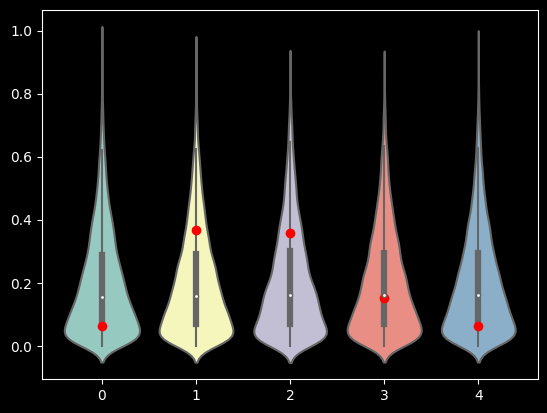

In [37]:
Kvec_post = sample['K']
print(Kvec_post.shape)
sns.violinplot(data=Kvec_post)
plt.plot(range(Kvec_post.shape[1]), K_truth[:,index], 'o', color='red')

In [197]:
K1 = jnp.array([[0.1, 0.1, 0.25], [0.5, 0.8, 0.35], [0.4, 0.1, 0.4]])
T1 =  solveOT(K1, a, b, 0.1)
T2 = solveOT(K1, a, b, 1)

In [200]:
print(jnp.sum(T1, axis=0))

[0.07140662 0.28544244 0.64315094]


[0.07142857 0.28571428 0.64285715]
